### [Bayesian regression with STAN: Part 1 normal regression](https://datascienceplus.com/bayesian-regression-with-stan-part-1-normal-regression/)

In [11]:
#load libraries
library(rstan)
library(coda)
library(dplyr)

```r

m_norm<-stan(file="normal_regression.stan",data = list(N=100,N2=60,K=4,y=y_norm,X=X,new_X=new_X),pars = c("beta","sigma","y_pred"))


normal_regression.stan


/*
*Simple normal regression example
*/

data {
  int N; //the number of observations
  int N2; //the size of the new_X matrix
  int K; //the number of columns in the model matrix
  real y[N]; //the response
  matrix[N,K] X; //the model matrix
  matrix[N2,K] new_X; //the matrix for the predicted values
}
parameters {
  vector[K] beta; //the regression parameters
  real sigma; //the standard deviation
}
transformed parameters {
  vector[N] linpred;
  linpred <- X*beta;
}
model {  
  beta[1] ~ cauchy(0,10); //prior for the intercept following Gelman 2008

  for(i in 2:K)
   beta[i] ~ cauchy(0,2.5);//prior for the slopes following Gelman 2008
  
  y ~ normal(linpred,sigma);
}
generated quantities {
  vector[N2] y_pred;
  y_pred <- new_X*beta; //the y values predicted by the model
}
```

In [14]:
set.seed(20151204)
#the explanatory variables
dat<-data.frame(x1=runif(100,-2,2),x2=runif(100,-2,2))
dat  %>%  head()

x1,x2
0.09984757,-0.0899424
-1.48204678,1.9916501
0.16605956,-0.4637859
1.18992614,-0.1920065
0.58558920,-0.5824747
0.76781662,0.2761313


In [16]:
#the model
X<-model.matrix(~x1*x2,dat)
head(X)

,(Intercept),x1,x2,x1:x2
1,1,0.09984757,-0.0899424,-0.00898053
2,1,-1.48204678,1.9916501,-2.95171863
3,1,0.16605956,-0.4637859,-0.07701608
4,1,1.18992614,-0.1920065,-0.22847360
5,1,0.58558920,-0.5824747,-0.34109091
6,1,0.76781662,0.2761313,0.21201819


In [19]:
#the regression slopes
betas<-runif(4,-1,1)
betas
#the standard deviation for the simulated data
sigma<-1

[1] -0.4767012 -0.8306625  0.1502558 -0.2629857

In [21]:
#the simulated data
y_norm<-rnorm(100,X%*%betas,sigma)
y_norm

[1] -0.91536980  0.70883362  0.04078934 -0.69778857 -1.30043952 -0.64744657
  [7]  4.17768189 -2.57666704  2.99205159 -0.25171514 -0.81396055 -2.11442238
 [13] -1.37134686 -0.45082934 -1.00429973 -0.34390890  1.09711625 -0.52491574
 [19] -2.18328898 -0.16802770 -1.03223931  0.06785483 -2.29562311 -1.64502524
 [25]  0.43200566 -1.68425036  1.15597342 -1.58640793  0.96003130  0.58208326
 [31]  0.58879684  1.69269793  1.00791704  1.21113634 -2.17701523 -0.06791985
 [37] -0.50339311  0.09266943 -2.85831666 -0.91846416 -1.59609843  0.31450700
 [43]  1.95273983 -1.37189331 -1.43316534  1.84230635 -0.77644583 -1.54237819
 [49]  1.34788665 -3.55626645 -1.76200239 -0.18672479 -1.93326719 -2.12483330
 [55] -0.81342148 -0.26825498 -0.52111409  0.51100016 -1.33984642 -1.77893762
 [61]  0.81909599  1.84216426  0.29173357  2.50064053 -0.92794614  0.84497312
 [67] -0.39360856  1.39123227 -0.22646417 -1.39444022  1.16964689  0.14706063
 [73] -0.89954203 -3.02606659  0.85193147 -0.83939556  0.77896350  1.23503591
 [79] -0.16773829 -0.65091500 -0.90303890  0.17815458 -1.28172257 -3.38452954
 [85] -0.70018468 -0.97463713  1.13203137  0.16322580  0.10434298 -0.52102771
 [91]  1.37537823  2.03257352  1.52029474  1.18008634 -1.24755493 -1.33806209
 [97]  0.71817038 -2.23602566 -2.06294901 -0.43240171

new_X matrix will be used to draw the regression lines as predicted by the model. It contains x1 values ordered from the smallest to biggest values as well as three specific x2 values, namely the minimum, mean and maximum value. This is necessary since x1 and x2 interact, we need to draw the regression lines predicted form the models at different values of x2.

In [23]:
#a matrix to get the predicted y values
new_X<-model.matrix(~x1*x2,expand.grid(x1=seq(min(dat$x1),max(dat$x1),length=20),x2=c(min(dat$x2),mean(dat$x2),max(dat$x2))))
new_X  %>%  head()

,(Intercept),x1,x2,x1:x2
1,1,-1.9874277,-1.934823,3.845321
2,1,-1.7811242,-1.934823,3.446160
3,1,-1.5748208,-1.934823,3.046999
4,1,-1.3685173,-1.934823,2.647839
5,1,-1.1622138,-1.934823,2.248678
6,1,-0.9559103,-1.934823,1.849517


The pars argument is used to specify which parameters to return.
STAN is in constant development, at the time of writing of this post with rstan version 2.8.2 I got a couple of warning that scale parameters are 0. Careful reading of the warning message reveal that there is nothing to worry about with my model. I therefore go one and plot some diagnostics plot.

In [3]:
#the location of the model files
setwd("/home/xenakas/Desktop/Git/bayesian_inference/STAN")
start_time <- Sys.time()
#the model
m_norm<-stan(file="normal_regression.stan",data = list(N=100,N2=60,K=4,y=y_norm,X=X,new_X=new_X),pars = c("beta","sigma","y_pred"))
end_time <- Sys.time()
end_time - start_time

DIAGNOSTIC(S) FROM PARSER:
Info (non-fatal): assignment operator <- deprecated in the Stan language; use = instead.
Info (non-fatal): assignment operator <- deprecated in the Stan language; use = instead.


SAMPLING FOR MODEL 'normal_regression' NOW (CHAIN 1).
Chain 1: Rejecting initial value:
Chain 1:   Error evaluating the log probability at the initial value.
Chain 1: Exception: normal_lpdf: Scale parameter is -1.96067, but must be > 0!  (in 'model1cc61ce77d3b_normal_regression' at line 27)

Chain 1: 
Chain 1: Gradient evaluation took 1.2e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.12 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]

Time difference of 50.11063 secs

In [33]:
summary(m_norm)$summary  %>%  head(10)
summary(m_norm)$summary  %>%  tail(10)

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
beta[1],-0.5999285,0.001548137,0.09897481,-0.7936402,-0.6652667,-0.5983488,-0.5310190,-0.4100258,4087.246,0.9996569
beta[2],-0.9385028,0.001204203,0.08172042,-1.0992254,-0.9928512,-0.9394707,-0.8843009,-0.7744968,4605.341,0.9998903
beta[3],0.7231856,0.001230116,0.08408502,0.5647582,0.6654071,0.7235782,0.7789095,0.8883970,4672.452,0.9998868
beta[4],-0.4736241,0.001136261,0.07049152,-0.6110803,-0.5215487,-0.4725007,-0.4244498,-0.3384481,3848.731,1.0011364
sigma,0.9643989,0.001133955,0.07176493,0.8373435,0.9135182,0.9594770,1.0093689,1.1147227,4005.277,0.9997369
y_pred[1],-1.9551948,0.005581859,0.37352524,-2.6935643,-2.2056004,-1.9563313,-1.7010932,-1.2227250,4477.980,1.0005214
y_pred[2],-1.9597591,0.005124520,0.34484080,-2.6359061,-2.1919957,-1.9605843,-1.7276341,-1.2887216,4528.255,1.0004637
y_pred[3],-1.9643233,0.004687375,0.31734426,-2.5822569,-2.1813589,-1.9640098,-1.7505894,-1.3475788,4583.550,1.0003931
y_pred[4],-1.9688876,0.004276619,0.29137212,-2.5269418,-2.1689818,-1.9677556,-1.7721430,-1.3943672,4641.891,1.0003074
y_pred[5],-1.9734518,0.003900598,0.26736900,-2.4781857,-2.1555511,-1.9751028,-1.7952334,-1.4450412,4698.504,1.0002053


,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
y_pred[52],0.30994098,0.002747626,0.1902062,-0.06061037,0.1813282,0.31169925,0.43926018,0.6805296,4792.191,1.000160
y_pred[53],-0.07828598,0.002943904,0.2017202,-0.46493093,-0.2150589,-0.07690439,0.05685799,0.3094382,4695.171,1.000319
y_pred[54],-0.46651295,0.003203163,0.2172477,-0.88443613,-0.6143276,-0.46692958,-0.32186937,-0.0500054,4599.944,1.000460
y_pred[55],-0.85473991,0.003511478,0.2359979,-1.31560987,-1.0150125,-0.85591564,-0.69911616,-0.3953192,4516.858,1.000574
y_pred[56],-1.24296688,0.003857103,0.2572671,-1.74534415,-1.4192702,-1.24444544,-1.07224188,-0.7443771,4448.832,1.000660
y_pred[57],-1.63119384,0.004230904,0.2804828,-2.17939989,-1.8214262,-1.63233465,-1.44361100,-1.0828844,4394.870,1.000724
y_pred[58],-2.01942081,0.004628108,0.3052011,-2.60836906,-2.2210874,-2.02216853,-1.81434779,-1.4251663,4348.759,1.000770
y_pred[59],-2.40764777,0.005045012,0.3310858,-3.04981662,-2.6295704,-2.40597225,-2.18510459,-1.7627092,4306.819,1.000802
y_pred[60],-2.79587474,0.005474469,0.3578837,-3.48669827,-3.0380027,-2.79343934,-2.55775419,-2.0939593,4273.658,1.000825
lp__,-45.69499080,0.039618936,1.6422047,-49.63758501,-46.5759230,-45.36572348,-44.47853699,-43.4907392,1718.102,1.001822


In [25]:
#plotting the posterior distribution for the parameters
post_beta<-As.mcmc.list(m_norm,pars="beta")
head(post_beta)

[[1]]
Markov Chain Monte Carlo (MCMC) output:
Start = 1001 
End = 1007 
Thinning interval = 1 
        beta[1]    beta[2]   beta[3]    beta[4]
[1,] -0.5882889 -1.0019426 0.6277833 -0.4494032
[2,] -0.5552466 -0.9949866 0.6583197 -0.5944648
[3,] -0.6606248 -0.8791225 0.7841895 -0.3228556
[4,] -0.6072916 -0.8860897 0.8103391 -0.5716269
[5,] -0.6839889 -0.9442573 0.6302610 -0.3996894
[6,] -0.4949920 -0.9651875 0.7164436 -0.4479243
[7,] -0.7430294 -0.9563427 0.7430073 -0.5177319

[[2]]
Markov Chain Monte Carlo (MCMC) output:
Start = 1001 
End = 1007 
Thinning interval = 1 
        beta[1]    beta[2]   beta[3]    beta[4]
[1,] -0.5508438 -0.7833562 0.7996472 -0.5948636
[2,] -0.6836035 -1.0851402 0.6319664 -0.3309326
[3,] -0.5772667 -1.0127230 0.5968530 -0.3786761
[4,] -0.6116805 -0.9058116 0.6017620 -0.4927594
[5,] -0.6606232 -0.9950445 0.7898446 -0.3820201
[6,] -0.6063881 -0.9704437 0.8307066 -0.4963199
[7,] -0.5800465 -0.9390094 0.6759006 -0.5079428

[[3]]
Markov Chain Monte Carlo (MCMC) ou

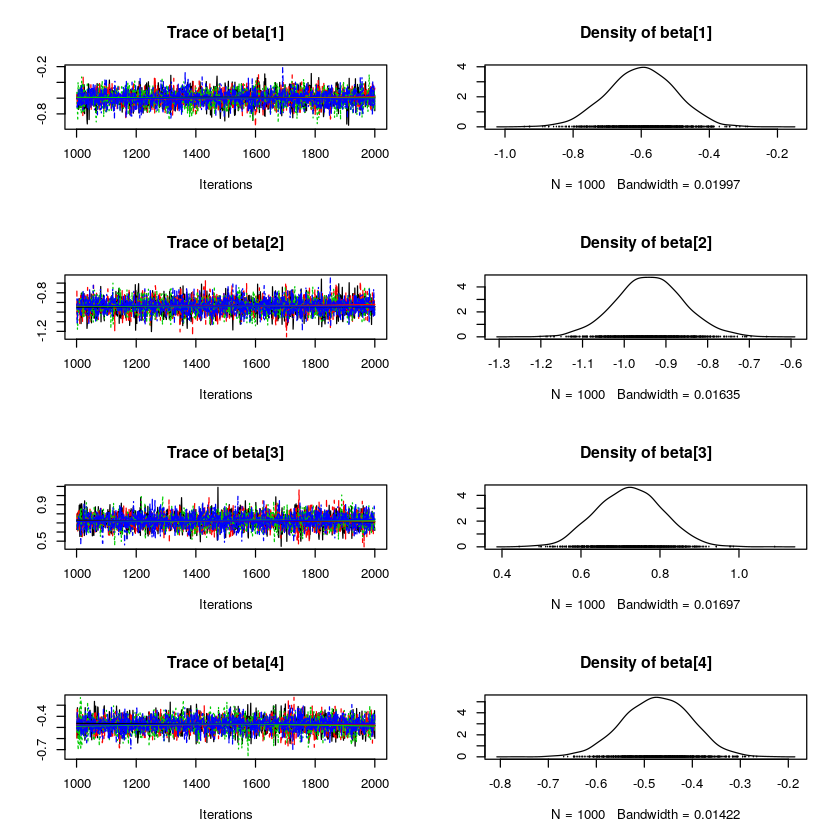

In [34]:
plot(post_beta)

In [40]:
apply(extract(m_norm,pars="beta")$beta,2,function(x) length(which(x>0)))

[1]    0    0 4000    0

In [35]:
#computing the posterior probability for the slopes to be bigger than 0
apply(extract(m_norm,pars="beta")$beta,2,function(x) length(which(x>0))/4000)

[1] 0 0 1 0

Another helpful summary plot is the pairwise correlation between the parameters, if each parameters is adding additional independent information, the points should form a shapeless cloud. If you have strong correlation between several parameters, then you may consider dropping some as they do not add extra information.

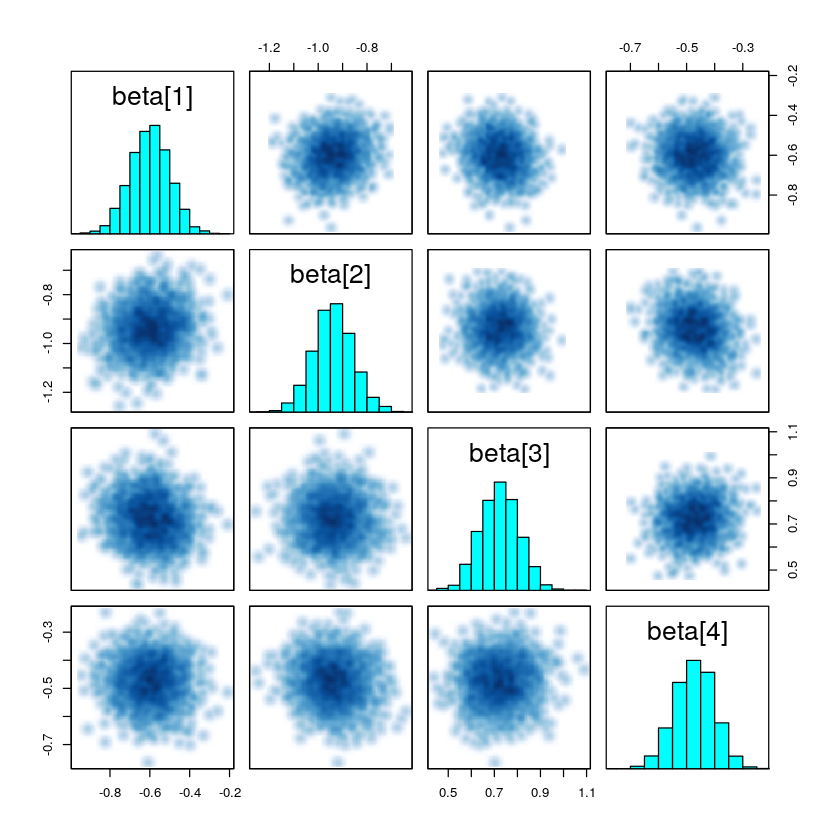

In [6]:
#plot the correlation between the parameters
pairs(m_norm,pars="beta")

ci_level: 0.8 (80% intervals)
outer_level: 0.95 (95% intervals)


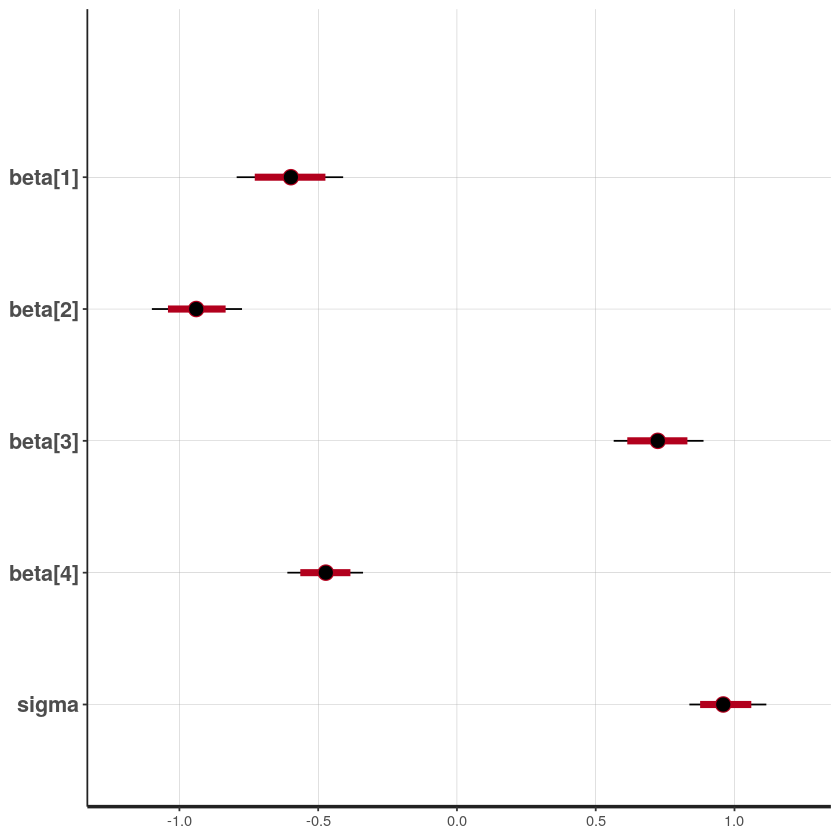

In [7]:
#plotting credible intervals for the different betas
plot(m_norm,pars=c("beta","sigma"))

In [42]:
#getting regression curves plus 95% credible intervals
new_x<-data.frame(x1=new_X[,2],x2=rep(c("Min","Mean","Max"),each=20))
new_x  %>%  head()

x1,x2
-1.9874277,Min
-1.7811242,Min
-1.5748208,Min
-1.3685173,Min
-1.1622138,Min
-0.9559103,Min


In [50]:
new_y<-extract(m_norm,pars="y_pred")
typeof(new_y)
dim(new_y$y_pred)

[1] "list"

[1] 4000   60

In [51]:
pred<-apply(new_y[[1]],2,quantile,probs=c(0.025,0.5,0.975)) #the median line with 95% credible intervals
pred

2.5%,-2.693564,-2.635906,-2.582257,-2.526942,-2.478186,-2.445564,-2.417462,-2.394705,-2.385216,-2.380361,⋯,0.3337981,-0.06061037,-0.46493093,-0.8844361,-1.3156099,-1.7453441,-2.179400,-2.608369,-3.049817,-3.486698
50%,-1.956331,-1.960584,-1.964010,-1.967756,-1.975103,-1.979412,-1.985155,-1.989862,-1.993593,-1.998449,⋯,0.6988262,0.31169925,-0.07690439,-0.4669296,-0.8559156,-1.2444454,-1.632335,-2.022169,-2.405972,-2.793439
97.5%,-1.222725,-1.288722,-1.347579,-1.394367,-1.445041,-1.496963,-1.536842,-1.570499,-1.587840,-1.600991,⋯,1.0552485,0.68052963,0.30943824,-0.0500054,-0.3953192,-0.7443771,-1.082884,-1.425166,-1.762709,-2.093959


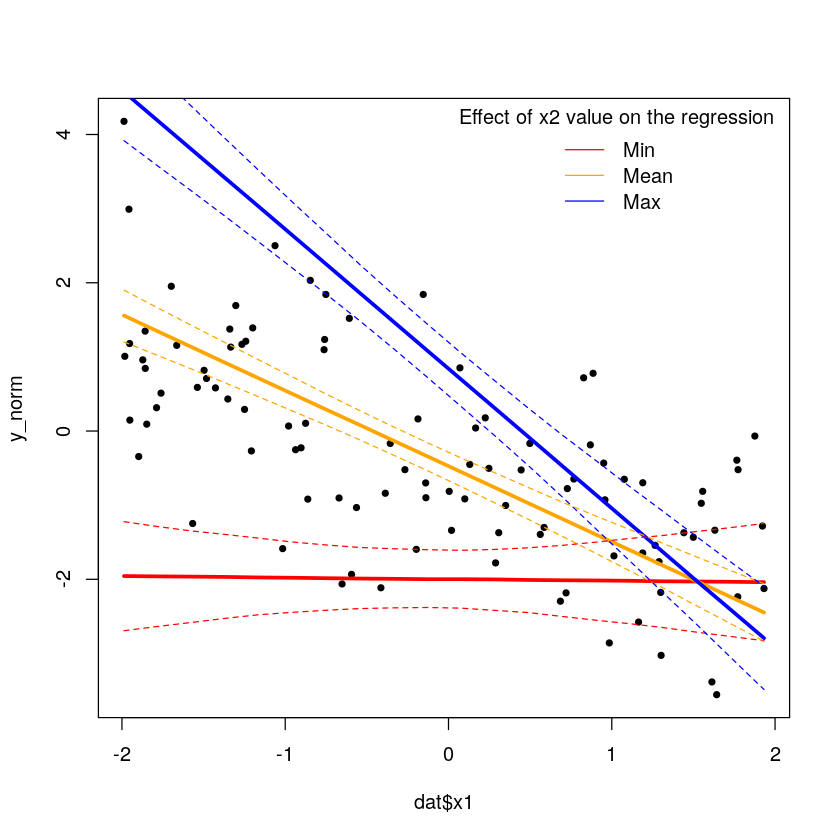

In [72]:
#plot
plot(dat$x1,y_norm,pch=20)

#medians
lines(new_x$x1[1:20],pred[2,1:20],col="red",lwd=3)
lines(new_x$x1[1:20],pred[2,21:40],col="orange",lwd=3)
lines(new_x$x1[1:20],pred[2,41:60],col="blue",lwd=3)

#2.5%
lines(new_x$x1[1:20],pred[1,1:20],col="red",lwd=1,lty=2)
lines(new_x$x1[1:20],pred[1,21:40],col="orange",lwd=1,lty=2)
lines(new_x$x1[1:20],pred[1,41:60],col="blue",lwd=1,lty=2)

#97.5%
lines(new_x$x1[1:20],pred[3,1:20],col="red",lwd=1,lty=2)
lines(new_x$x1[1:20],pred[3,21:40],col="orange",lwd=1,lty=2)
lines(new_x$x1[1:20],pred[3,41:60],col="blue",lwd=1,lty=2)

legend("topright",legend=c("Min","Mean","Max"),lty=1,col=c("red","orange","blue"),bty = "n",title = "Effect of x2 value on the regression")
